In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from operator import itemgetter

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import Rectangle

from SI_metrics import plot_coeff_grid
from data_processing import plot_fft

from deepSI import System_data

from utils import load_data

from scipy.interpolate import UnivariateSpline
from data_processing import confiy, plot_fft, generate_multi_sin_signal, add_gaussian_noise

c:\Users\Joost\anaconda3\envs\test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mlcolors = list(mcolors.TABLEAU_COLORS.values())
mlcolors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [3]:
data_set_name="sc_arrow_noisy"
x_data, u_data, y_data, eq, T, U, set_idx = load_data(set=data_set_name)
[N_arrow, N_train, N_val, N_test] = set_idx[0]

if T is None:
    T = np.eye(x_data.shape[-1])
if U is None:
    U = np.eye(u_data.shape[-1])

# data organizing
x_arrow, u_arrow = x_data[:N_arrow], u_data[:N_arrow,0]
x_train, u_train = x_data[N_arrow:N_arrow+N_train-N_val,:], u_data[N_arrow:N_arrow+N_train-N_val,0]
x_val, u_val     = x_data[N_arrow+N_train-N_val:-N_test,:], u_data[N_arrow+N_train-N_val:-N_test,0]
x_test, u_test   = x_data[-N_test:,:], u_data[-N_test:]

# system data
arrow   = System_data(u=u_arrow, y=x_arrow)
train   = System_data(u=u_train, y=x_train)
val     = System_data(u=u_val[:1000], y=x_val[:1000,:])
test    = System_data(u=u_test, y=x_test)

Data loaded from sc_arrow_noisy!


In [4]:
data_set_name="us_arrow_noisy"
x_data, u_data, y_data, eq, _, _, set_idx = load_data(set=data_set_name)
[N_arrow, N_train, N_val, N_test] = set_idx[0]

if T is None:
    T = np.eye(x_data.shape[-1])
if U is None:
    U = np.eye(u_data.shape[-1])

# data organizing
x_arrow, u_arrow = x_data[:N_arrow], u_data[:N_arrow,0]
x_train, u_train = x_data[N_arrow:N_arrow+N_train-N_val,:], u_data[N_arrow:N_arrow+N_train-N_val,0]
x_val, u_val     = x_data[N_arrow+N_train-N_val:-N_test,:], u_data[N_arrow+N_train-N_val:-N_test,0]
x_test, u_test   = x_data[-N_test:,:], u_data[-N_test:]

# system data
us_arrow   = System_data(u=u_arrow, y=x_arrow)
us_train   = System_data(u=u_train, y=x_train)
us_val     = System_data(u=u_val[:1000], y=x_val[:1000,:])
us_test    = System_data(u=u_test, y=x_test)

Data loaded from us_arrow_noisy!


In [5]:
def NRMS(x_true, x_pred):
    rms = np.sqrt(np.mean((x_true-x_pred)**2, axis=0))
    return rms, rms/np.std(x_true, axis=0)

In [6]:
base_dir = 'result_runs'

In [7]:
data_dir = 'thvsparv2'
data_path = os.path.join(base_dir, data_dir)

data_container = []

metrics = ['nf', 'threshold', 'NRMS_arrow', "best_NRMS_arrow", 'NRMS_test', "best_NRMS_test"]
metrics_array = ['epoch_id', 'Loss_val', 'Loss_train', 'arrow_sim_enc', 'test_sim_enc', 'coeff']
equations = 'eq_res'

for i in os.listdir(data_path):
    data_i = os.path.join(data_path, i)
    with open(data_i, "rb") as file:
        data_container.append(pickle.load(file))

metrics_df      = pd.DataFrame(columns=metrics+["best_x1_terms", "best_x2_terms", "last_x1_terms", "last_x2_terms"])
epoch_id        = data_container[0]['epoch_id'] # same for all
func_labels     = data_container[0]['feature_names'] # same for all
equation_list   = []

for idx, data_ci in enumerate(data_container):
    best_terms_x1, best_terms_x2 = list((data_ci["best_weights"].numpy()!=0).sum(1))
    N_f = len(data_ci['feature_names'])
    last_terms_x1, last_terms_x2 = np.where(data_ci["coeff"][:N_f,-1]!=0)[0].shape[0], np.where(data_ci["coeff"][N_f:,-1]!=0)[0].shape[0]

    metrics_df.loc[len(metrics_df.index)] = itemgetter(*metrics)(data_ci) +(best_terms_x1, best_terms_x2, last_terms_x1, last_terms_x2)
    equation_list.append(data_ci[equations])

    if not idx:
        Loss_val    = [data_ci['Loss_val']]
        Loss_train  = [data_ci['Loss_train']]
    else:
        Loss_val    = np.vstack([Loss_val, data_ci['Loss_val']])
        Loss_train  = np.vstack([Loss_val, data_ci['Loss_train']])


# # sorting based on th
metrics_df      = metrics_df.sort_values(by=['threshold'])
order = list(metrics_df.index)

equation_list   = [equation_list[i] for i in order]


Loss_val = Loss_val.T[:,order]
Loss_train = Loss_train.T[:,order]

metrics_df

,nf,threshold,NRMS_arrow,best_NRMS_arrow,NRMS_test,best_NRMS_test,best_x1_terms,best_x2_terms,last_x1_terms,last_x2_terms
12,1.0,0.000005,0.084019,0.084019,0.067871,0.067871,36.0,35.0,36.0,35.0
3,1.0,0.000010,0.107745,0.107745,0.086875,0.086875,34.0,30.0,33.0,30.0
7,1.0,0.000020,0.092710,0.092710,0.075896,0.075896,28.0,21.0,28.0,21.0
11,1.0,0.000050,0.084800,0.084800,0.061717,0.061717,23.0,12.0,23.0,12.0
2,1.0,0.000100,0.081228,0.081228,0.073774,0.073774,8.0,20.0,4.0,15.0
6,1.0,0.000200,0.084291,0.084291,0.069529,0.069529,7.0,9.0,7.0,9.0
10,1.0,0.000500,0.080289,0.080289,0.067175,0.067175,2.0,9.0,2.0,5.0
1,1.0,0.001000,0.090692,0.090692,0.072219,0.072219,2.0,4.0,2.0,4.0
5,1.0,0.002000,0.090435,0.090435,0.071806,0.071806,2.0,4.0,2.0,4.0
9,1.0,0.005000,0.434216,0.434216,0.308118,0.308118,6.0,6.0,2.0,3.0


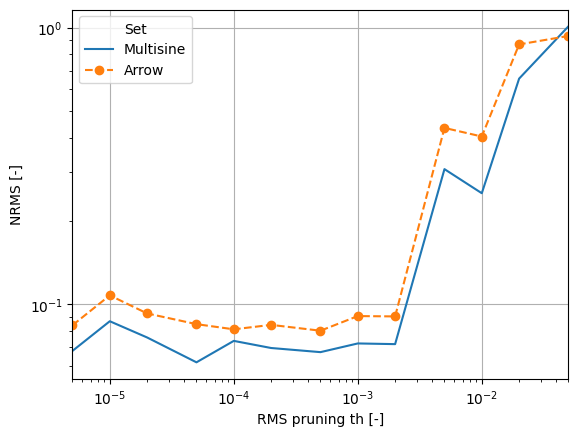

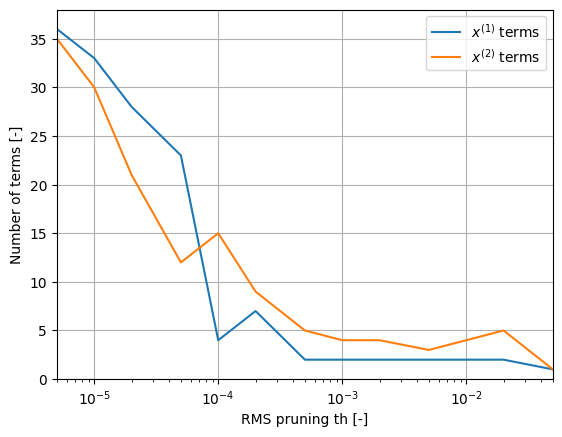

In [8]:
plt.loglog(metrics_df["threshold"].values, metrics_df["best_NRMS_test"].values, label="Multisine", linestyle="-")
plt.loglog(metrics_df["threshold"].values, metrics_df["best_NRMS_arrow"].values, label="Arrow", linestyle="--", marker="o")


plt.xlabel("RMS pruning th [-]")
plt.ylabel("NRMS [-]")
plt.legend(title="Set")
plt.grid()
plt.xlim([np.min(metrics_df["threshold"].values), np.max(metrics_df["threshold"].values)])

# plt.savefig('thvsnrms.png', dpi=450, transparent=True)
# plt.ylim([0, 1])

plt.show()


plt.semilogx(metrics_df["threshold"].values, metrics_df["last_x1_terms"].values, label="$x^{(1)}\\text{ terms}$")
plt.semilogx(metrics_df["threshold"].values, metrics_df["last_x2_terms"].values, label="$x^{(2)}\\text{ terms}$")

plt.xlabel("RMS pruning th [-]")
plt.ylabel("Number of terms [-]")
plt.legend()
plt.grid()
plt.xlim([np.min(metrics_df["threshold"].values), np.max(metrics_df["threshold"].values)])
plt.ylim([0, 38])

# plt.savefig('thvsnrterms.png', dpi=450, transparent=True)

plt.show()


In [9]:
data_dir = 'nftest_wnl'
data_path = os.path.join(base_dir, data_dir)

data_container = []

metrics = ['nf', 'threshold', 'NRMS_arrow', "best_NRMS_arrow", 'NRMS_test', "best_NRMS_test"]
metrics_array = ['epoch_id', 'Loss_val', 'Loss_train', 'arrow_sim_enc', 'test_sim_enc', 'coeff']
equations = 'eq_res'

for i in os.listdir(data_path):
    data_i = os.path.join(data_path, i)
    with open(data_i, "rb") as file:
        data_container.append(pickle.load(file))

metrics_df      = pd.DataFrame(columns=metrics+["best_x1_terms", "best_x2_terms", "last_x1_terms", "last_x2_terms"])
epoch_id        = data_container[0]['epoch_id'] # same for all
func_labels     = data_container[0]['feature_names'] # same for all
equation_list   = []

for idx, data_ci in enumerate(data_container):
    best_terms_x1, best_terms_x2 = list((data_ci["best_weights"].numpy()!=0).sum(1))
    N_f = len(data_ci['feature_names'])
    last_terms_x1, last_terms_x2 = np.where(data_ci["coeff"][:N_f,-1]!=0)[0].shape[0], np.where(data_ci["coeff"][N_f:,-1]!=0)[0].shape[0]

    metrics_df.loc[len(metrics_df.index)] = itemgetter(*metrics)(data_ci) +(best_terms_x1, best_terms_x2, last_terms_x1, last_terms_x2)
    equation_list.append(data_ci[equations])

    if not idx:
        Loss_val    = [data_ci['Loss_val']]
        Loss_train  = [data_ci['Loss_train']]

        x1_terms_epoch_i= [np.count_nonzero(data_ci["coeff"][:N_f,:], axis=0)]
        x2_terms_epoch_i= [np.count_nonzero(data_ci["coeff"][N_f:,:], axis=0)]
    else:
        Loss_val    = np.vstack([Loss_val, data_ci['Loss_val']])
        Loss_train  = np.vstack([Loss_train, data_ci['Loss_train']])

        # x1_terms_epoch_i= np.vstack([x1_terms_epoch_i, np.count_nonzero(data_ci["coeff"][:N_f,:], axis=0)])
        # x2_terms_epoch_i= np.vstack([x2_terms_epoch_i, np.count_nonzero(data_ci["coeff"][N_f:,:], axis=0)])
        

# # sorting based on th
metrics_df      = metrics_df.sort_values(by=['nf'])
order = list(metrics_df.index)

equation_list   = [equation_list[i] for i in order]

Loss_val         = Loss_val.T[:,order]
Loss_train       = Loss_train.T[:,order]
# x1_terms_epoch_i = x1_terms_epoch_i.T[:,order]
# x2_terms_epoch_i = x2_terms_epoch_i.T[:,order]

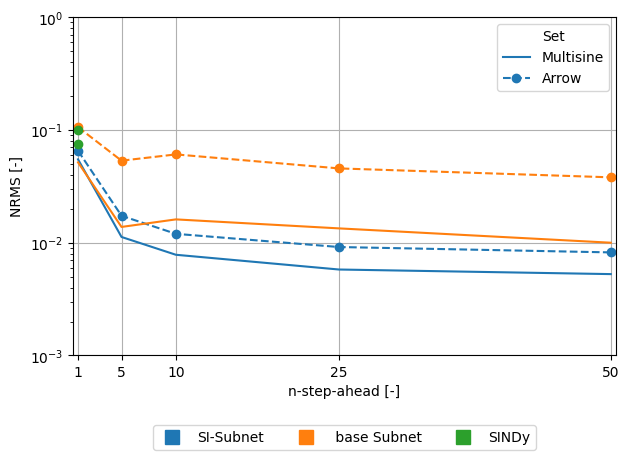

In [10]:
SINDy_test_incomp, SINDy_arrow_incomp = 0.07459745060432106, 0.09985790009320593
SUBNET_test_wnl = [0.0516, 0.0138, 0.0161, 0.0134, 0.0100]
SUBNET_arrow_wnl = [0.106,0.0534,0.0607,0.0456,0.0380]

plt.semilogy(metrics_df['nf'].values,  metrics_df["best_NRMS_test"].values, color='#1f77b4', linestyle="-", label="Multisine")
plt.semilogy(metrics_df['nf'].values, metrics_df["best_NRMS_arrow"].values, color='#1f77b4', linestyle="--", marker="o", label="Arrow")

plt.semilogy(metrics_df['nf'].values,  SUBNET_test_wnl, color='#ff7f0e', linestyle= "-")
plt.semilogy(metrics_df['nf'].values, SUBNET_arrow_wnl, color='#ff7f0e', linestyle= "--", marker="o")

plt.semilogy(1, SINDy_test_incomp,  color='#2ca02c', marker="o")
plt.semilogy(1, SINDy_arrow_incomp,  color='#2ca02c', marker="o")

plt.xlabel("n-step-ahead [-]")
plt.ylabel("NRMS [-]")
plt.xticks(metrics_df['nf'].values, labels=[str(int(i)) for i in metrics_df['nf'].values])
plt.xlim([0.5, 50.5])
plt.ylim([10**-3, 10**0])

set_legend = plt.legend(loc='upper right', title="Set")
plt.gca().add_artist(set_legend)

custom_lines = [
    # Line2D([0], [0], color='#1f77b4', marker='s', linestyle='None', markersize=10, label='SI-Subnet (complete)'),
    Line2D([0], [0], color='#1f77b4', marker='s', linestyle='None', markersize=10, label='SI-Subnet'),
    Line2D([0], [0], color='#ff7f0e', marker='s', linestyle='None', markersize=10, label=' base Subnet'),
    # Line2D([0], [0], color='#2ca02c', marker='s', linestyle='None', markersize=10, label='SINDy (complete)'),
    Line2D([0], [0], color='#2ca02c', marker='s', linestyle='None', markersize=10, label='SINDy')
]

# Add a single legend below all subplots with colored squares
plt.legend(handles=custom_lines, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)

plt.grid()

plt.tight_layout()
# plt.savefig('u_ideal_presi.png', dpi=450, transparent=True,bbox_inches='tight')
plt.show()

In [11]:
nf = np.array([1,5,10,25,50])

c_SUBNET_test = np.array([0.0324 , 0.00634, 0.00612, 0.00587, 0.0034 ])
c_SUBNET_arrow = np.array([0.09942, 0.04301, 0.04239, 0.02892, 0.01858])
c_SINDy_test, c_SINDy_arrow = 0.07170043998367062, 0.08982289481808038
c_SI_SUBNET_test = np.array([0.07341813, 0.0170132 , 0.00915957, 0.00840937, 0.00235307])
c_SI_SUBNET_arrow= np.array([0.09012748, 0.02295994, 0.01255504, 0.01006669, 0.00296629])


i_SINDy_test, i_SINDy_arrow = 0.07459745060432106, 0.09985790009320593
i_SUBNET_test = [0.0516, 0.0138, 0.0161, 0.0134, 0.0100]
i_SUBNET_arrow = [0.106,0.0534,0.0607,0.0456,0.0380]
i_SI_SUBNET_test = np.array([0.06488014, 0.01124337, 0.00781721, 0.00578495, 0.00526678])
i_SI_SUBNET_arrow= np.array([0.07539537, 0.01733585, 0.01198636, 0.00915721, 0.00820566])

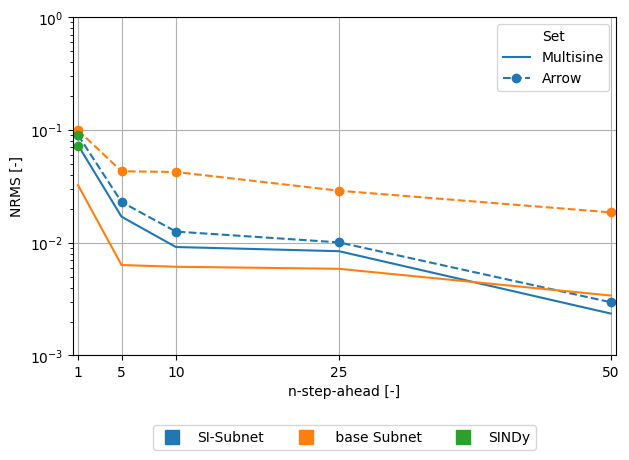

In [12]:
plt.semilogy(metrics_df['nf'].values,  c_SI_SUBNET_test, color='#1f77b4', linestyle="-", label="Multisine")
plt.semilogy(metrics_df['nf'].values, c_SI_SUBNET_arrow, color='#1f77b4', linestyle="--", marker="o", label="Arrow")

plt.semilogy(metrics_df['nf'].values,  c_SUBNET_test, color='#ff7f0e', linestyle= "-")
plt.semilogy(metrics_df['nf'].values, c_SUBNET_arrow, color='#ff7f0e', linestyle= "--", marker="o")

plt.semilogy(1, c_SINDy_test,  color='#2ca02c', marker="o")
plt.semilogy(1, c_SINDy_arrow,  color='#2ca02c', marker="o")

plt.xlabel("n-step-ahead [-]")
plt.ylabel("NRMS [-]")
plt.xticks(metrics_df['nf'].values, labels=[str(int(i)) for i in metrics_df['nf'].values])
plt.xlim([0.5, 50.5])
plt.ylim([10**-3, 10**0])

set_legend = plt.legend(loc='upper right', title="Set")
plt.gca().add_artist(set_legend)

custom_lines = [
    # Line2D([0], [0], color='#1f77b4', marker='s', linestyle='None', markersize=10, label='SI-Subnet (complete)'),
    Line2D([0], [0], color='#1f77b4', marker='s', linestyle='None', markersize=10, label='SI-Subnet'),
    Line2D([0], [0], color='#ff7f0e', marker='s', linestyle='None', markersize=10, label=' base Subnet'),
    # Line2D([0], [0], color='#2ca02c', marker='s', linestyle='None', markersize=10, label='SINDy (complete)'),
    Line2D([0], [0], color='#2ca02c', marker='s', linestyle='None', markersize=10, label='SINDy')
]

# Add a single legend below all subplots with colored squares
plt.legend(handles=custom_lines, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)

plt.grid()

plt.tight_layout()
# plt.savefig('u_ideal_presi.png', dpi=450, transparent=True,bbox_inches='tight')
plt.show()

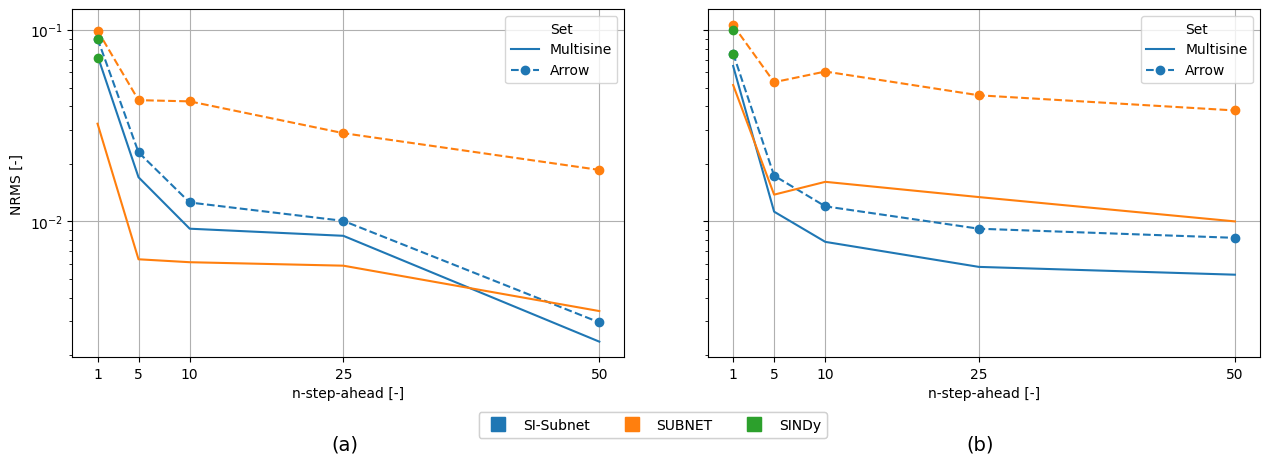

In [13]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12.8, 4.8))
ax1.semilogy(nf,c_SI_SUBNET_test, linestyle="-", color=mlcolors[0], label="Multisine")
ax1.semilogy(nf,c_SI_SUBNET_arrow, linestyle="--", marker="o", color=mlcolors[0], label="Arrow")

ax1.semilogy(nf,c_SUBNET_test, linestyle="-", color=mlcolors[1])
ax1.semilogy(nf,c_SUBNET_arrow, linestyle="--", marker="o", color=mlcolors[1])

ax1.semilogy(1,c_SINDy_test, marker="o", color=mlcolors[2])
ax1.semilogy(1,c_SINDy_arrow, marker="o", color=mlcolors[2])
ax1.set_xticks(ticks=nf,labels=nf)
ax1.legend(loc='upper right', title="Set")
ax1.grid()
ax1.text(0.494, -0.25, '(a)', transform=ax1.transAxes, fontsize=14, va='center', ha="center")
ax1.set_xlabel("n-step-ahead [-]")
ax1.set_ylabel("NRMS [-]")


ax2.semilogy(nf,i_SI_SUBNET_test, linestyle="-", color=mlcolors[0], label="Multisine")
ax2.semilogy(nf,i_SI_SUBNET_arrow, linestyle="--", marker="o", color=mlcolors[0], label="Arrow")

ax2.semilogy(nf,i_SUBNET_test, linestyle="-", color=mlcolors[1])
ax2.semilogy(nf,i_SUBNET_arrow, linestyle="--", marker="o", color=mlcolors[1])

ax2.semilogy(1,i_SINDy_test, marker="o", color=mlcolors[2])
ax2.semilogy(1,i_SINDy_arrow, marker="o", color=mlcolors[2])
ax2.set_xticks(ticks=nf,labels=nf)
ax2.legend(loc='upper right', title="Set")
ax2.set_xlabel("n-step-ahead [-]")

# ax2.text(1.5255, -0.25, '(b)', transform=ax1.transAxes, fontsize=14, va='center', ha="center")
ax2.text(1.645, -0.25, '(b)', transform=ax1.transAxes, fontsize=14, va='center', ha="center")

ax2_leg = ax2.legend(loc='upper right', title="Set")
plt.gca().add_artist(ax2_leg)

ax2.grid()

custom_lines = [
    Line2D([0], [0], color='#1f77b4', marker='s', linestyle='None', markersize=10, label='SI-Subnet'),
    Line2D([0], [0], color='#ff7f0e', marker='s', linestyle='None', markersize=10, label='SUBNET'),
    Line2D([0], [0], color='#2ca02c', marker='s', linestyle='None', markersize=10, label='SINDy')
]

# Add a single legend below all subplots with colored squares

figure_legend = plt.legend(handles=custom_lines, loc='lower center', bbox_to_anchor=(-0.1, -0.25), ncol=3)
plt.gca().add_artist(figure_legend)
figure_legend.set_zorder(3)
plt.subplots_adjust(wspace=0.8, hspace=0) 
plt.tight_layout()
# plt.savefig('NRMSvsnf_idealvsnideal.png', dpi=450, transparent=True,bbox_inches='tight')
plt.show()

*****NFTEST*****

In [14]:
# ###########################################################################
# ###########################################################################
# best_val_sc = np.zeros((2, len(Loss_val)))

# for idx, val in enumerate(Loss_val):
#     best_val_sc[0, idx] = val[-1]

#     if not idx:
#         Loss_val_ext = np.r_[val, np.random.normal(val[-2], np.std([val[60:70]])/2.2,(201-val.shape[0]))]
#         pretrain_sec = val[:51]

#         best_val_sc[1, idx] = np.where(Loss_val_ext==val[-1])[0][0]
#     else:
#         Loss_val_i = np.r_[pretrain_sec, val[50:], np.random.normal(val[-2], np.std([val[60:70]])/2.2,(150-val[50:].shape[0]))]
#         Loss_val_ext = np.vstack([Loss_val_ext, Loss_val_i])
#         best_val_sc[1, idx] = np.where(Loss_val_i==val[-1])[0][0]

# # pretrain section
# plt.semilogy(np.arange(start=0,step=1,stop=51),Loss_val_ext.T[:51,0], color=mlcolors[0])

# # after pretrain
# plt.semilogy(np.arange(start=50,step=1,stop=201),Loss_val_ext.T[50:,0], color=mlcolors[0], label="nf=1")     # nf=1
# plt.semilogy(np.arange(start=50,step=1,stop=201),Loss_val_ext.T[50:,3], color=mlcolors[1], label="nf=5")     # nf=5
# plt.semilogy(np.arange(start=50,step=1,stop=201),Loss_val_ext.T[50:,1], color=mlcolors[2], label="nf=10")     # nf=10
# plt.semilogy(np.arange(start=50,step=1,stop=201),Loss_val_ext.T[50:,2], color=mlcolors[3], label="nf=25")     # nf=25
# plt.semilogy(np.arange(start=50,step=1,stop=201),Loss_val_ext.T[50:,4], color=mlcolors[4], label="nf=50")     # nf=50

# # best NRMS
# plt.semilogy(best_val_sc[1,:], best_val_sc[0,:], "ro", label="best epoch")

# plt.vlines(x=50, ymin=0, ymax=5, color='r', linestyles='-', alpha=0.5)

# plt.vlines(x=60, ymin=0, ymax=5, color='r', linestyles='--', alpha=0.5)
# plt.vlines(x=70, ymin=0, ymax=5, color='r', linestyles='--', alpha=0.5)
# plt.vlines(x=80, ymin=0, ymax=5, color='r', linestyles='--', alpha=0.5)

# plt.vlines(x=90, ymin=0, ymax=1.6, color='r', linestyles='--', alpha=0.5)
# plt.vlines(x=90, ymin=2.4, ymax=5, color='r', linestyles='--', alpha=0.5)

# plt.vlines(x=100, ymin=0, ymax=1.6, color='r', linestyles='--', alpha=0.5)
# plt.vlines(x=100, ymin=2.4, ymax=5, color='r', linestyles='--', alpha=0.5)

# plt.vlines(x=110, ymin=0, ymax=1.6, color='r', linestyles='--', alpha=0.5)
# plt.vlines(x=110, ymin=2.4, ymax=5, color='r', linestyles='--', alpha=0.5)

# plt.vlines(x=120, ymin=0, ymax=5, color='r', linestyles='--', alpha=0.5)
# plt.vlines(x=130, ymin=0, ymax=5, color='r', linestyles='--', alpha=0.5)
# plt.vlines(x=140, ymin=0, ymax=5, color='r', linestyles='--', alpha=0.5)

# plt.vlines(x=150, ymin=0, ymax=5, color='r', linestyles='-', alpha=0.5)

# # for i in range(int((Loss_val_ext.shape[-1]-50)/5)):
# #     plt.vlines(x=50+i*5, ymin=0, ymax=5, color='r', linestyles='--', alpha=0.5)

# plt.text(25, 2, "Phase 1", fontweight='bold', va='center', ha='center')
# plt.text(100, 2, "Phase 2", fontweight='bold', va='center', ha='center')
# plt.text(175, 2, "Phase 3", fontweight='bold', va='center', ha='center')

# plt.xlim([0, 200])
# plt.xlabel("epoch [-]")
# plt.ylabel("Validation simulation NRMS [-]")
# plt.legend(loc=3, fontsize='small')

# # plt.savefig('validationLossnfTest.png', dpi=450, transparent=True, bbox_inches='tight')

# plt.show()
# ###########################################################################
# ###########################################################################

In [15]:
data_dir = 'th_wnl'
data_path = os.path.join(base_dir, data_dir)

data_container = []

metrics = ['nf', 'threshold', 'NRMS_arrow', "best_NRMS_arrow", 'NRMS_test', "best_NRMS_test"]
metrics_array = ['epoch_id', 'Loss_val', 'Loss_train', 'arrow_sim_enc', 'test_sim_enc', 'coeff']
equations = 'eq_res'

for i in os.listdir(data_path):
    data_i = os.path.join(data_path, i)
    with open(data_i, "rb") as file:
        data_container.append(pickle.load(file))

metrics_df      = pd.DataFrame(columns=metrics+["best_x1_terms", "best_x2_terms", "last_x1_terms", "last_x2_terms"])
epoch_id        = data_container[0]['epoch_id'] # same for all
func_labels     = data_container[0]['feature_names'] # same for all
equation_list   = []

for idx, data_ci in enumerate(data_container):
    best_terms_x1, best_terms_x2 = list((data_ci["best_weights"].numpy()!=0).sum(1))
    N_f = len(data_ci['feature_names'])
    last_terms_x1, last_terms_x2 = np.where(data_ci["coeff"][:N_f,-1]!=0)[0].shape[0], np.where(data_ci["coeff"][N_f:,-1]!=0)[0].shape[0]

    metrics_df.loc[len(metrics_df.index)] = itemgetter(*metrics)(data_ci) +(best_terms_x1, best_terms_x2, last_terms_x1, last_terms_x2)
    equation_list.append(data_ci[equations])

    if not idx:
        Loss_val    = [data_ci['Loss_val']]
        Loss_train  = [data_ci['Loss_train']]

        x1_terms_epoch_i= [np.count_nonzero(data_ci["coeff"][:N_f,:], axis=0)]
        x2_terms_epoch_i= [np.count_nonzero(data_ci["coeff"][N_f:,:], axis=0)]
    else:
        Loss_val    = np.vstack([Loss_val, data_ci['Loss_val']])
        Loss_train  = np.vstack([Loss_train, data_ci['Loss_train']])

        x1_terms_epoch_i= np.vstack([x1_terms_epoch_i, np.count_nonzero(data_ci["coeff"][:N_f,:], axis=0)])
        x2_terms_epoch_i= np.vstack([x2_terms_epoch_i, np.count_nonzero(data_ci["coeff"][N_f:,:], axis=0)])
        

# # sorting based on th
metrics_df      = metrics_df.sort_values(by=['threshold'])
order = list(metrics_df.index)

equation_list   = [equation_list[i] for i in order]

Loss_val         = Loss_val.T[:,order]
Loss_train       = Loss_train.T[:,order]
x1_terms_epoch_i = x1_terms_epoch_i.T[:,order]
x2_terms_epoch_i = x2_terms_epoch_i.T[:,order]

metrics_df

,nf,threshold,NRMS_arrow,best_NRMS_arrow,NRMS_test,best_NRMS_test,best_x1_terms,best_x2_terms,last_x1_terms,last_x2_terms
4,5.0,0.00001,0.030994,0.023232,0.024414,0.016496,30.0,32.0,30.0,32.0
8,5.0,0.00002,0.029309,0.021240,0.021568,0.014737,19.0,27.0,19.0,26.0
12,5.0,0.00004,0.029904,0.022540,0.024885,0.014826,9.0,15.0,9.0,15.0
16,5.0,0.00008,0.027946,0.019806,0.020702,0.013007,4.0,10.0,4.0,10.0
3,5.0,0.00010,0.026744,0.021826,0.019632,0.014188,4.0,9.0,4.0,9.0
7,5.0,0.00020,0.026543,0.020585,0.018999,0.012914,3.0,8.0,3.0,8.0
11,5.0,0.00040,0.028743,0.022394,0.021171,0.015330,2.0,8.0,2.0,8.0
15,5.0,0.00080,0.029776,0.023905,0.022776,0.017291,2.0,7.0,2.0,7.0
2,5.0,0.00100,0.026339,0.024119,0.019960,0.017472,2.0,7.0,2.0,7.0
6,5.0,0.00200,0.028820,0.023717,0.022392,0.017219,2.0,7.0,2.0,7.0


In [16]:
grouped = metrics_df.groupby(["last_x1_terms","last_x2_terms"]).agg(
    occurerences=("last_x2_terms","size"),
    score_test=('NRMS_test','first'),
    score_arrow=('NRMS_arrow','first')
).reset_index()

In [17]:
grouped     = grouped.sort_values(by=['score_arrow'])

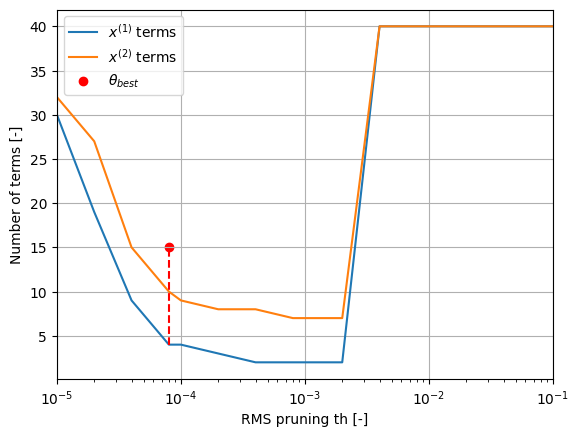

In [18]:
plt.semilogx(metrics_df["threshold"].values, metrics_df["best_x1_terms"].values, label="$x^{(1)}\\text{ terms}$")
plt.semilogx(metrics_df["threshold"].values, metrics_df["best_x2_terms"].values, label="$x^{(2)}\\text{ terms}$")

plt.vlines(0.00008, metrics_df["best_x1_terms"].values[4], 15, color='r', linestyles='--')
plt.scatter(0.00008, 15, marker='o', color='r', label="$\\theta_{best}$")

plt.xlabel("RMS pruning th [-]")
plt.ylabel("Number of terms [-]")
plt.legend()
plt.grid()
plt.xlim([np.min(metrics_df["threshold"].values), np.max(metrics_df["threshold"].values)])

# plt.savefig('pruningth.png', dpi=450, transparent=True, bbox_inches='tight')

plt.show()

In [19]:
data_dir = 'lambda_wnl_large'
data_path = os.path.join(base_dir, data_dir)

data_container = []

metrics = ['nf','gamma', 'threshold', 'epo_idx', 'NRMS_arrow', "best_NRMS_arrow", 'NRMS_test', "best_NRMS_test"]
metrics_array = ['epoch_id', 'Loss_val', 'Loss_train', 'arrow_sim_enc', 'test_sim_enc', 'coeff']
equations = 'eq_res'

for i in os.listdir(data_path):
    data_i = os.path.join(data_path, i)
    with open(data_i, "rb") as file:
        data_container.append(pickle.load(file))

metrics_df      = pd.DataFrame(columns=metrics+["best_x1_terms", "best_x2_terms", "last_x1_terms", "last_x2_terms"])
epoch_id        = data_container[0]['epoch_id'] # same for all
func_labels     = data_container[0]['feature_names'] # same for all
equation_list   = []

for idx, data_ci in enumerate(data_container):
    best_terms_x1, best_terms_x2 = list((data_ci["best_weights"].numpy()!=0).sum(1))
    N_f = len(data_ci['feature_names'])
    last_terms_x1, last_terms_x2 = np.where(data_ci["coeff"][:N_f,-1]!=0)[0].shape[0], np.where(data_ci["coeff"][N_f:,-1]!=0)[0].shape[0]

    metrics_df.loc[len(metrics_df.index)] = itemgetter(*metrics)(data_ci) +(best_terms_x1, best_terms_x2, last_terms_x1, last_terms_x2)
    equation_list.append(data_ci[equations])

    if not idx:
        Loss_val    = [data_ci['Loss_val']]
        Loss_train  = [data_ci['Loss_train']]

        x1_terms_epoch_i= [np.count_nonzero(data_ci["coeff"][:N_f,:], axis=0)]
        x2_terms_epoch_i= [np.count_nonzero(data_ci["coeff"][N_f:,:], axis=0)]
    else:
        Loss_val    = np.vstack([Loss_val, data_ci['Loss_val']])
        Loss_train  = np.vstack([Loss_train, data_ci['Loss_train']])

        x1_terms_epoch_i= np.vstack([x1_terms_epoch_i, np.count_nonzero(data_ci["coeff"][:N_f,:], axis=0)])
        x2_terms_epoch_i= np.vstack([x2_terms_epoch_i, np.count_nonzero(data_ci["coeff"][N_f:,:], axis=0)])
        

# # sorting based on th
metrics_df      = metrics_df.sort_values(by=['gamma'])
order = list(metrics_df.index)

equation_list   = [equation_list[i] for i in order]

Loss_val         = Loss_val.T[:,order]
Loss_train       = Loss_train.T[:,order]
x1_terms_epoch_i = x1_terms_epoch_i.T[:,order]
x2_terms_epoch_i = x2_terms_epoch_i.T[:,order]

metrics_df

,nf,gamma,threshold,epo_idx,NRMS_arrow,best_NRMS_arrow,NRMS_test,best_NRMS_test,best_x1_terms,best_x2_terms,last_x1_terms,last_x2_terms
3,1.0,0.00001,0.0005,49.0,0.103759,0.070399,0.095236,0.051284,17.0,20.0,11.0,12.0
7,1.0,0.00002,0.0005,49.0,0.109887,0.067642,0.096485,0.056080,9.0,14.0,9.0,12.0
11,1.0,0.00005,0.0005,49.0,0.099470,0.063684,0.089242,0.053996,5.0,12.0,5.0,12.0
15,1.0,0.00008,0.0005,49.0,0.085363,0.066184,0.082067,0.057923,9.0,11.0,9.0,9.0
2,1.0,0.00010,0.0005,49.0,0.089505,0.086444,0.071129,0.061261,9.0,14.0,9.0,14.0
6,1.0,0.00020,0.0005,49.0,0.087709,0.065855,0.078336,0.052017,6.0,13.0,6.0,13.0
10,1.0,0.00050,0.0005,49.0,0.122895,0.076973,0.109937,0.054624,8.0,12.0,8.0,12.0
14,1.0,0.00080,0.0005,49.0,0.090902,0.071281,0.082683,0.050323,12.0,16.0,11.0,12.0
1,1.0,0.00100,0.0005,49.0,0.079507,0.088293,0.068585,0.058902,11.0,12.0,8.0,12.0
5,1.0,0.00200,0.0005,49.0,0.100530,0.064003,0.090499,0.047520,12.0,12.0,12.0,12.0


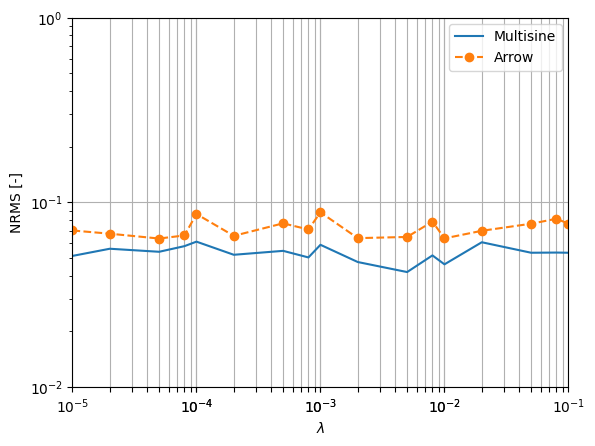

In [20]:
plt.loglog(np.r_[metrics_df['gamma'].values, 0.1], np.r_[metrics_df['best_NRMS_test'].values, metrics_df['best_NRMS_test'].values[-2]], label="Multisine")
plt.loglog(np.r_[metrics_df['gamma'].values, 0.1], np.r_[metrics_df['best_NRMS_arrow'].values, metrics_df['best_NRMS_arrow'].values[-2]],"--o", label="Arrow")
plt.ylim([1e-2, 1])
plt.xlim([10**-5, 10**-1])
plt.legend()
plt.xticks(np.r_[[(1+i)*10**-5 for i in range(10)], [(1+i)*10**-4 for i in range(10)], [(1+i)*10**-3 for i in range(10)], [(1+i)*10**-2 for i in range(10)]])
plt.grid()
plt.xlabel("$\\lambda$")
plt.ylabel("NRMS [-]")
# plt.savefig('regularization.png', dpi=450, transparent=True, bbox_inches='tight')
plt.show()

In [21]:
# data_container[0]["feature_names"]

In [22]:
data_dir = 'nftest_long'
data_path = os.path.join(base_dir, data_dir)

data_container = []

metrics = ['nf', 'threshold', 'NRMS_arrow', "best_NRMS_arrow", 'NRMS_test', "best_NRMS_test"]
metrics_array = ['epoch_id', 'Loss_val', 'Loss_train', 'arrow_sim_enc', 'test_sim_enc', 'coeff']
equations = 'eq_res'

for i in os.listdir(data_path):
    data_i = os.path.join(data_path, i)
    with open(data_i, "rb") as file:
        data_container.append(pickle.load(file))

metrics_df      = pd.DataFrame(columns=metrics+["best_x1_terms", "best_x2_terms", "last_x1_terms", "last_x2_terms"])
epoch_id        = data_container[0]['epoch_id'] # same for all
func_labels     = data_container[0]['feature_names'] # same for all
equation_list   = []

for idx, data_ci in enumerate(data_container):
    best_terms_x1, best_terms_x2 = list((data_ci["best_weights"].numpy()!=0).sum(1))
    N_f = len(data_ci['feature_names'])
    last_terms_x1, last_terms_x2 = np.where(data_ci["coeff"][:N_f,-1]!=0)[0].shape[0], np.where(data_ci["coeff"][N_f:,-1]!=0)[0].shape[0]

    metrics_df.loc[len(metrics_df.index)] = itemgetter(*metrics)(data_ci) +(best_terms_x1, best_terms_x2, last_terms_x1, last_terms_x2)
    equation_list.append(data_ci[equations])

    if not idx:
        Loss_val    = [data_ci['Loss_val']]
        Loss_train  = [data_ci['Loss_train']]

        x1_terms_epoch_i= [np.count_nonzero(data_ci["coeff"][:N_f,:], axis=0)]
        x2_terms_epoch_i= [np.count_nonzero(data_ci["coeff"][N_f:,:], axis=0)]
    else:
        Loss_val    = np.vstack([Loss_val, data_ci['Loss_val']])
        Loss_train  = np.vstack([Loss_train, data_ci['Loss_train']])

        x1_terms_epoch_i= np.vstack([x1_terms_epoch_i, np.count_nonzero(data_ci["coeff"][:N_f,:], axis=0)])
        x2_terms_epoch_i= np.vstack([x2_terms_epoch_i, np.count_nonzero(data_ci["coeff"][N_f:,:], axis=0)])
        

# # sorting based on th
metrics_df      = metrics_df.sort_values(by=['nf'])
order = list(metrics_df.index)

equation_list   = [equation_list[i] for i in order]

Loss_val         = Loss_val.T[:,order]
Loss_train       = Loss_train.T[:,order]
x1_terms_epoch_i = x1_terms_epoch_i.T[:,order]
x2_terms_epoch_i = x2_terms_epoch_i.T[:,order]

metrics_df

,nf,threshold,NRMS_arrow,best_NRMS_arrow,NRMS_test,best_NRMS_test,best_x1_terms,best_x2_terms,last_x1_terms,last_x2_terms
0,1.0,0.0005,0.084362,0.082798,0.066921,0.065200,5.0,7.0,5.0,7.0
3,5.0,0.0005,0.023061,0.027389,0.017003,0.013464,12.0,14.0,2.0,4.0
1,10.0,0.0005,0.012498,0.008162,0.008709,0.006155,2.0,4.0,2.0,4.0
2,25.0,0.0005,0.003642,0.002876,0.003291,0.002339,2.0,4.0,2.0,4.0
4,50.0,0.0005,0.002077,0.001486,0.002205,0.001379,2.0,4.0,2.0,4.0


In [23]:
data_dir = 'lambda_wnl_large'
data_path = os.path.join(base_dir, data_dir)

data_container = []

metrics = ['nf','gamma', 'threshold', 'epo_idx', 'NRMS_arrow', "best_NRMS_arrow", 'NRMS_test', "best_NRMS_test"]
metrics_array = ['epoch_id', 'Loss_val', 'Loss_train', 'arrow_sim_enc', 'test_sim_enc', 'coeff']
equations = 'eq_res'

for i in os.listdir(data_path):
    data_i = os.path.join(data_path, i)
    with open(data_i, "rb") as file:
        data_container.append(pickle.load(file))

metrics_df      = pd.DataFrame(columns=metrics+["best_x1_terms", "best_x2_terms", "last_x1_terms", "last_x2_terms"])
epoch_id        = data_container[0]['epoch_id'] # same for all
func_labels     = data_container[0]['feature_names'] # same for all
equation_list   = []

for idx, data_ci in enumerate(data_container):
    best_terms_x1, best_terms_x2 = list((data_ci["best_weights"].numpy()!=0).sum(1))
    N_f = len(data_ci['feature_names'])
    last_terms_x1, last_terms_x2 = np.where(data_ci["coeff"][:N_f,-1]!=0)[0].shape[0], np.where(data_ci["coeff"][N_f:,-1]!=0)[0].shape[0]

    metrics_df.loc[len(metrics_df.index)] = itemgetter(*metrics)(data_ci) +(best_terms_x1, best_terms_x2, last_terms_x1, last_terms_x2)
    equation_list.append(data_ci[equations])

    if not idx:
        Loss_val    = [data_ci['Loss_val']]
        Loss_train  = [data_ci['Loss_train']]

        x1_terms_epoch_i= [np.count_nonzero(data_ci["coeff"][:N_f,:], axis=0)]
        x2_terms_epoch_i= [np.count_nonzero(data_ci["coeff"][N_f:,:], axis=0)]
    else:
        Loss_val    = np.vstack([Loss_val, data_ci['Loss_val']])
        Loss_train  = np.vstack([Loss_train, data_ci['Loss_train']])

        x1_terms_epoch_i= np.vstack([x1_terms_epoch_i, np.count_nonzero(data_ci["coeff"][:N_f,:], axis=0)])
        x2_terms_epoch_i= np.vstack([x2_terms_epoch_i, np.count_nonzero(data_ci["coeff"][N_f:,:], axis=0)])
        

# # sorting based on th
metrics_df      = metrics_df.sort_values(by=['gamma'])
order = list(metrics_df.index)

equation_list   = [equation_list[i] for i in order]

Loss_val         = Loss_val.T[:,order]
Loss_train       = Loss_train.T[:,order]
x1_terms_epoch_i = x1_terms_epoch_i.T[:,order]
x2_terms_epoch_i = x2_terms_epoch_i.T[:,order]

metrics_df

,nf,gamma,threshold,epo_idx,NRMS_arrow,best_NRMS_arrow,NRMS_test,best_NRMS_test,best_x1_terms,best_x2_terms,last_x1_terms,last_x2_terms
3,1.0,0.00001,0.0005,49.0,0.103759,0.070399,0.095236,0.051284,17.0,20.0,11.0,12.0
7,1.0,0.00002,0.0005,49.0,0.109887,0.067642,0.096485,0.056080,9.0,14.0,9.0,12.0
11,1.0,0.00005,0.0005,49.0,0.099470,0.063684,0.089242,0.053996,5.0,12.0,5.0,12.0
15,1.0,0.00008,0.0005,49.0,0.085363,0.066184,0.082067,0.057923,9.0,11.0,9.0,9.0
2,1.0,0.00010,0.0005,49.0,0.089505,0.086444,0.071129,0.061261,9.0,14.0,9.0,14.0
6,1.0,0.00020,0.0005,49.0,0.087709,0.065855,0.078336,0.052017,6.0,13.0,6.0,13.0
10,1.0,0.00050,0.0005,49.0,0.122895,0.076973,0.109937,0.054624,8.0,12.0,8.0,12.0
14,1.0,0.00080,0.0005,49.0,0.090902,0.071281,0.082683,0.050323,12.0,16.0,11.0,12.0
1,1.0,0.00100,0.0005,49.0,0.079507,0.088293,0.068585,0.058902,11.0,12.0,8.0,12.0
5,1.0,0.00200,0.0005,49.0,0.100530,0.064003,0.090499,0.047520,12.0,12.0,12.0,12.0


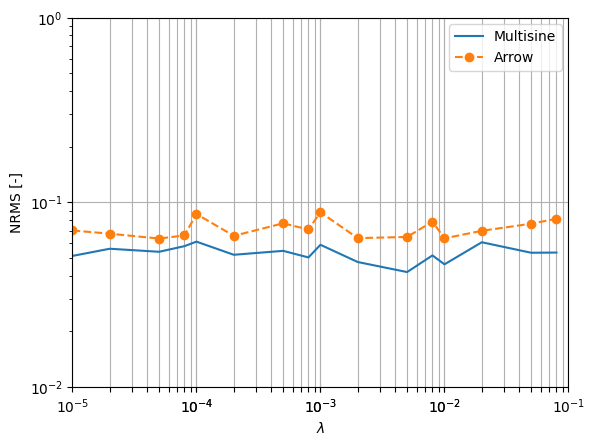

0.053205651232927045
0.0722742140498025
0.005080184677448916
0.007904709565319698


(None, None)

In [24]:
plt.loglog(np.r_[metrics_df['gamma'].values], np.r_[metrics_df['best_NRMS_test'].values], label="Multisine")
plt.loglog(np.r_[metrics_df['gamma'].values], np.r_[metrics_df['best_NRMS_arrow'].values],"--o", label="Arrow")
plt.ylim([1e-2, 1])
plt.xlim([10**-5, 10**-1])
plt.legend()
plt.xticks(np.r_[[(1+i)*10**-5 for i in range(10)], [(1+i)*10**-4 for i in range(10)], [(1+i)*10**-3 for i in range(10)], [(1+i)*10**-2 for i in range(10)]])
plt.grid()
plt.xlabel("$\\lambda$")
plt.ylabel("NRMS [-]")
# plt.savefig('regularization.png', dpi=450, transparent=True, bbox_inches='tight')
plt.show()

print(np.mean(metrics_df['best_NRMS_test'].values)), print(np.mean(metrics_df['best_NRMS_arrow'].values))

print(np.std(metrics_df['best_NRMS_test'].values)), print(np.std(metrics_df['best_NRMS_arrow'].values))

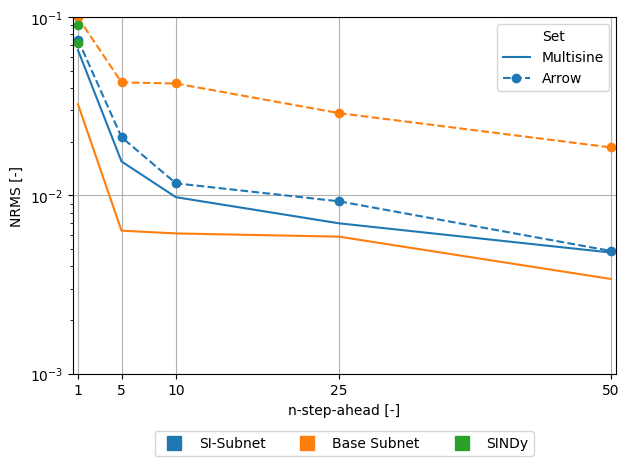

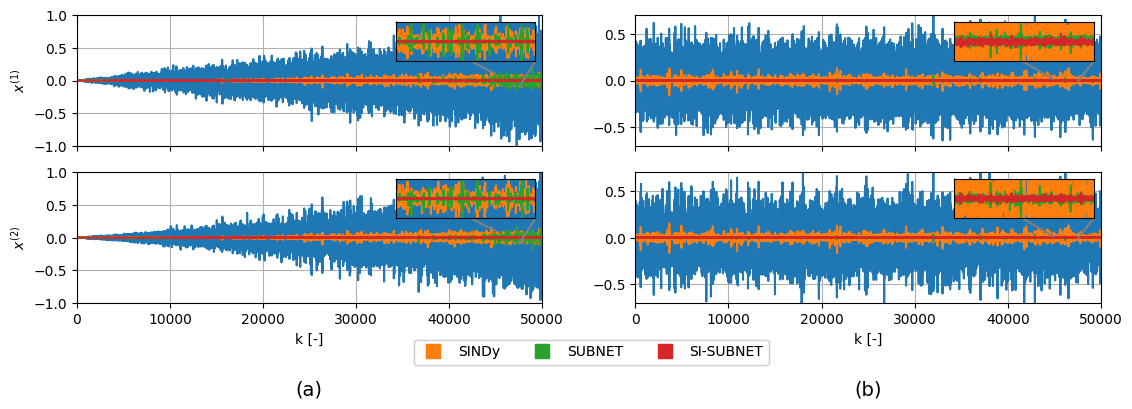

In [25]:
data_dir = 'nftest_good1'
data_path = os.path.join(base_dir, data_dir)

data_container = []

for i in os.listdir(data_path):
    data_i = os.path.join(data_path, i)
    with open(data_i, "rb") as file:
        data_container.append(pickle.load(file))

metrics = ['nf', 'threshold', 'NRMS_arrow', "best_NRMS_arrow", 'NRMS_test', "best_NRMS_test"]
metrics_array = ['epoch_id', 'Loss_val', 'Loss_train', 'arrow_sim_enc', 'test_sim_enc', 'coeff']
equations = 'eq_res'

metrics_df      = pd.DataFrame(columns=metrics)
epoch_id        = data_container[0]['epoch_id'] # same for all
func_labels     = data_container[0]['feature_names'] # same for all
equation_list   = []

for idx, data_ci in enumerate(data_container):
    metrics_df.loc[len(metrics_df.index)] = itemgetter(*metrics)(data_ci)
    equation_list.append(data_ci[equations])

    if not idx:
        Loss_val    = [data_ci['Loss_val']]
        Loss_train  = [data_ci['Loss_train']]
    else:
        Loss_val.append(data_ci['Loss_val'])
        Loss_train.append(data_ci['Loss_train'])

# sorting based on th
metrics_df      = metrics_df.sort_values(by=['nf'])
order = list(metrics_df.index)

equation_list   = [equation_list[i] for i in order]

###########################################################################
############################# PLOT NF VS NRMS #############################
base_SUBNET_test = np.array([3.24, 0.634, 0.612, 0.587, 0.340])/100
base_SUBNET_arrow = np.array([9.942, 4.301, 4.239, 2.892, 1.858])/100
SINDy_test, SINDy_arrow = 0.07170043998367062, 0.08982289481808038

comp_arrow = metrics_df["best_NRMS_arrow"].values
comp_test = metrics_df["best_NRMS_test"].values

### SI subnet
plt.semilogy(metrics_df['nf'].values,  metrics_df["best_NRMS_test"].values, color='#1f77b4', linestyle="-", label="Multisine")
plt.semilogy(metrics_df['nf'].values, metrics_df["best_NRMS_arrow"].values, color='#1f77b4', linestyle="--", marker="o", label="Arrow")
### SUBNET
plt.semilogy(metrics_df['nf'].values,  base_SUBNET_test, color='#ff7f0e', linestyle= "-")
plt.semilogy(metrics_df['nf'].values, base_SUBNET_arrow, color='#ff7f0e', linestyle= "--", marker="o")

plt.semilogy(1,  SINDy_test, color='#2ca02c', linestyle="-", marker="o")
plt.semilogy(1, SINDy_arrow, color='#2ca02c', linestyle="--", marker="o")

plt.xlabel("n-step-ahead [-]")
plt.ylabel("NRMS [-]")
plt.xticks(metrics_df['nf'].values, labels=[str(int(i)) for i in metrics_df['nf'].values])
plt.xlim([0.5, 50.5])
plt.ylim([10**-3, 10**-1])

set_legend = plt.legend(loc='upper right', title="Set")
plt.gca().add_artist(set_legend)

custom_lines = [
    Line2D([0], [0], color='#1f77b4', marker='s', linestyle='None', markersize=10, label='SI-Subnet'),
    Line2D([0], [0], color='#ff7f0e', marker='s', linestyle='None', markersize=10, label='Base Subnet'),
    Line2D([0], [0], color='#2ca02c', marker='s', linestyle='None', markersize=10, label='SINDy')
]

# Add a single legend below all subplots with colored squares
plt.legend(handles=custom_lines, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)

plt.grid()

plt.tight_layout()
# plt.savefig('NRMSvsnf.png', dpi=450, transparent=True)
plt.show()


SINDy_arrow = np.load(r"result_runs\\SINDy_arrow_sim.npy")
SINDy_test = np.load(r"result_runs\\SINDy_test_sim.npy")

SUBNET_arrow_res = np.load(r"result_runs\\subnet_arrow_res.npy")
SUBNET_test_res = np.load(r"result_runs\\subnet_test_res.npy")

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(12.8, 4.8))

x1_SINDy_res_arrow = arrow.y[:,0]-SINDy_arrow[:,0]
x1_SISUBNET_res_arrow = (arrow.y[:,0]-data_container[4]['best_arrow_sim_enc'][:,0])
x1_SUBNET_res_arrow = T[0,0]*SUBNET_arrow_res[:,0]

x1_z, x2_z, y1_z, y2_z = 45000, 47500, -0.1, 0.1
axins = inset_axes(axs[0,0], width="30%", height="30%", loc='upper right')
axins.plot(arrow.y[:,0])
axins.plot(x1_SINDy_res_arrow)
axins.plot(x1_SUBNET_res_arrow)
axins.plot(x1_SISUBNET_res_arrow)
axins.set_xlim(x1_z, x2_z)
axins.set_ylim(y1_z, y2_z)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xticks([])
axins.set_yticks([])
mark_inset(axs[0,0], axins, loc1=2, loc2=4, fc="none", ec="0.5", lw=1.5)

axs[0,0].plot(arrow.y[:,0])
axs[0,0].plot(x1_SINDy_res_arrow, label="SINDy")
axs[0,0].plot(x1_SUBNET_res_arrow, label="SUBNET")
axs[0,0].plot(x1_SISUBNET_res_arrow, label="SI-SUBNET")

# ax1.legend(loc=3)
# ax1.xlim([0, arrow.y.shape[0]])
axs[0,0].set_ylim([-1, 1])
axs[0,0].set_ylabel("$x^{(1)}$")
# ax1.xlabel("k [-]")
axs[0,0].grid()

x2_SINDy_res_arrow = arrow.y[:,1]-SINDy_arrow[:,1]
x2_SISUBNET_res_arrow = (arrow.y[:,1]-data_container[4]['best_arrow_sim_enc'][:,1])
x2_SUBNET_res_arrow = T[1,1]*SUBNET_arrow_res[:,1]

x1_z, x2_z, y1_z, y2_z = 45000, 47500, -0.1, 0.1
axins = inset_axes(axs[1,0], width="30%", height="30%", loc='upper right')
axins.plot(arrow.y[:,1])
axins.plot(x2_SINDy_res_arrow)
axins.plot(x2_SUBNET_res_arrow)
axins.plot(x2_SISUBNET_res_arrow)
axins.set_xlim(x1_z, x2_z)
axins.set_ylim(y1_z, y2_z)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xticks([])
axins.set_yticks([])
mark_inset(axs[1,0], axins, loc1=2, loc2=4, fc="none", ec="0.5", lw=1.5)

axs[1,0].plot(arrow.y[:,1])
axs[1,0].plot(x2_SINDy_res_arrow, label="SINDy")
axs[1,0].plot(x2_SUBNET_res_arrow, label="SUBNET")
axs[1,0].plot(x2_SISUBNET_res_arrow, label="SI-SUBNET")

# ax2.legend(loc=3)
axs[1,0].set_xlim([0, arrow.y.shape[0]])
axs[1,0].set_ylim([-1, 1])
axs[1,0].set_ylabel("$x^{(2)}$")
axs[1,0].set_xlabel("k [-]")
axs[1,0].grid()

# test x1
x1_SINDy_res_test = test.y[:,0]-SINDy_test[:,0]
x1_SISUBNET_res_test = (test.y[:,0]-data_container[4]['best_test_sim_enc'][:,0])
x1_SUBNET_res_test = T[0,0]*SUBNET_test_res[:,0]

x1_z, x2_z, y1_z, y2_z = 45000, 47500, -0.01, 0.01
axins = inset_axes(axs[0,1], width="30%", height="30%", loc='upper right')
axins.plot(test.y[:,0])
axins.plot(x1_SINDy_res_test)
axins.plot(x1_SUBNET_res_test)
axins.plot(x1_SISUBNET_res_test)
axins.set_xlim(x1_z, x2_z)
axins.set_ylim(y1_z, y2_z)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xticks([])
axins.set_yticks([])
mark_inset(axs[0,1], axins, loc1=2, loc2=4, fc="none", ec="0.5", lw=1.5)


axs[0,1].plot(test.y[:,0])
axs[0,1].plot(x1_SINDy_res_test, label="SINDy")
axs[0,1].plot(x1_SUBNET_res_test, label="SUBNET")
axs[0,1].plot(x1_SISUBNET_res_test, label="SI-SUBNET")

# ax1.legend(loc=3)
# ax1.xlim([0, test.y.shape[0]])
axs[0,1].set_ylim([-0.7, 0.7])
# axs[0,1].set_ylabel("$x^{(1)}$")
# plt.xlabel("k [-]")
axs[0,1].grid()

# test x2
x2_SINDy_res_test = test.y[:,1]-SINDy_test[:,1]
x2_SISUBNET_res_test = (test.y[:,1]-data_container[4]['best_test_sim_enc'][:,1])
x2_SUBNET_res_test = T[1,1]*SUBNET_test_res[:,1]

axs[1,1].plot(test.y[:,1])
axs[1,1].plot(x2_SINDy_res_test, label="SINDy")
axs[1,1].plot(x2_SUBNET_res_test, label="SUBNET")
axs[1,1].plot(x2_SISUBNET_res_test, label="SI-SUBNET")

x1_z, x2_z, y1_z, y2_z = 45000, 47500, -0.01, 0.01
axins = inset_axes(axs[1,1], width="30%", height="30%", loc='upper right')
axins.plot(test.y[:,1])
axins.plot(x2_SINDy_res_test)
axins.plot(x2_SUBNET_res_test)
axins.plot(x2_SISUBNET_res_test)
axins.set_xlim(x1_z, x2_z)
axins.set_ylim(y1_z, y2_z)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xticks([])
axins.set_yticks([])
mark_inset(axs[1,1], axins, loc1=2, loc2=4, fc="none", ec="0.5", lw=1.5)

# ax2.legend(loc=3)
axs[1,1].set_xlim([0, test.y.shape[0]])
axs[1,1].set_ylim([-0.7, 0.7])
# axs[1,1].set_ylabel("$x^{(2)}$")
axs[1,1].set_xlabel("k [-]")
axs[1,1].grid()

custom_lines = [
    # Line2D([0], [0], color='#1f77b4', marker='s', linestyle='None', markersize=10, label='Test set'),
    Line2D([0], [0], color='#ff7f0e', marker='s', linestyle='None', markersize=10, label='SINDy'),#'$NRMS_{SINDy}=8.98\\%$'
    Line2D([0], [0], color='#2ca02c', marker='s', linestyle='None', markersize=10, label='SUBNET'),#'$NRMS_{SUBNET}=1.86\\%$'
    Line2D([0], [0], color='#d62728', marker='s', linestyle='None', markersize=10, label="SI-SUBNET")#"$NRMS_{SI-SUBNET}=0.29\\%$"
]

# Add a single legend below all subplots with colored squares
figure_legend = plt.legend(handles=custom_lines, loc='lower center', bbox_to_anchor=(-2.6, -3.9), ncol=3)
plt.gca().add_artist(figure_legend)
figure_legend.set_zorder(3)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)

plt.text(0.718, 0.12, '(b)', fontsize=14,transform=fig.transFigure, va='center', ha="center")
plt.text(0.281, 0.12, '(a)', fontsize=14,transform=fig.transFigure, va='center', ha="center")

# fig.set_size_inches(12.8, 4.8)
# plt.savefig('arrow_residuals_final.png', dpi=450, transparent=True, bbox_inches="tight")
plt.show()
###########################################################################
###########################################################################


In [26]:
data_dir = 'lambda_nf5'
data_path = os.path.join(base_dir, data_dir)

data_container = []

metrics = ['nf','gamma', 'threshold', 'epo_idx', 'NRMS_arrow', "best_NRMS_arrow", 'NRMS_test', "best_NRMS_test"]
metrics_array = ['epoch_id', 'Loss_val', 'Loss_train', 'arrow_sim_enc', 'test_sim_enc', 'coeff']
equations = 'eq_res'

for i in os.listdir(data_path):
    data_i = os.path.join(data_path, i)
    with open(data_i, "rb") as file:
        data_container.append(pickle.load(file))

metrics_df      = pd.DataFrame(columns=metrics+["best_x1_terms", "best_x2_terms", "last_x1_terms", "last_x2_terms"])
epoch_id        = data_container[0]['epoch_id'] # same for all
func_labels     = data_container[0]['feature_names'] # same for all
equation_list   = []

for idx, data_ci in enumerate(data_container):
    best_terms_x1, best_terms_x2 = list((data_ci["best_weights"].numpy()!=0).sum(1))
    N_f = len(data_ci['feature_names'])
    last_terms_x1, last_terms_x2 = np.where(data_ci["coeff"][:N_f,-1]!=0)[0].shape[0], np.where(data_ci["coeff"][N_f:,-1]!=0)[0].shape[0]

    metrics_df.loc[len(metrics_df.index)] = itemgetter(*metrics)(data_ci) +(best_terms_x1, best_terms_x2, last_terms_x1, last_terms_x2)
    equation_list.append(data_ci[equations])

    if not idx:
        Loss_val    = [data_ci['Loss_val']]
        Loss_train  = [data_ci['Loss_train']]

        x1_terms_epoch_i= [np.count_nonzero(data_ci["coeff"][:N_f,:], axis=0)]
        x2_terms_epoch_i= [np.count_nonzero(data_ci["coeff"][N_f:,:], axis=0)]
    else:
        Loss_val    = np.vstack([Loss_val, data_ci['Loss_val']])
        Loss_train  = np.vstack([Loss_train, data_ci['Loss_train']])

        x1_terms_epoch_i= np.vstack([x1_terms_epoch_i, np.count_nonzero(data_ci["coeff"][:N_f,:], axis=0)])
        x2_terms_epoch_i= np.vstack([x2_terms_epoch_i, np.count_nonzero(data_ci["coeff"][N_f:,:], axis=0)])
        

# # sorting based on th
metrics_df      = metrics_df.sort_values(by=['gamma'])
order = list(metrics_df.index)

equation_list   = [equation_list[i] for i in order]

Loss_val         = Loss_val.T[:,order]
Loss_train       = Loss_train.T[:,order]
x1_terms_epoch_i = x1_terms_epoch_i.T[:,order]
x2_terms_epoch_i = x2_terms_epoch_i.T[:,order]

metrics_df

,nf,gamma,threshold,epo_idx,NRMS_arrow,best_NRMS_arrow,NRMS_test,best_NRMS_test,best_x1_terms,best_x2_terms,last_x1_terms,last_x2_terms
4,5.0,0.00001,0.00008,9.0,0.033604,0.044215,0.032363,0.030516,30.0,34.0,30.0,34.0
8,5.0,0.00002,0.00008,9.0,0.038238,0.028876,0.031683,0.025196,30.0,34.0,30.0,34.0
12,5.0,0.00005,0.00008,9.0,0.038994,0.028031,0.037315,0.023857,31.0,33.0,31.0,33.0
16,5.0,0.00008,0.00008,9.0,0.044723,0.037497,0.045960,0.026887,30.0,34.0,30.0,34.0
3,5.0,0.00010,0.00008,9.0,0.053456,0.035780,0.045903,0.027059,31.0,33.0,31.0,33.0
7,5.0,0.00020,0.00008,9.0,0.034253,0.030902,0.037565,0.028230,30.0,34.0,30.0,34.0
11,5.0,0.00050,0.00008,9.0,0.030107,0.034326,0.027767,0.026588,30.0,34.0,30.0,34.0
15,5.0,0.00080,0.00008,9.0,0.036232,0.031914,0.038786,0.024051,31.0,33.0,31.0,33.0
2,5.0,0.00100,0.00008,9.0,0.029496,0.024386,0.025834,0.021972,30.0,34.0,30.0,34.0
6,5.0,0.00200,0.00008,9.0,0.034988,0.026082,0.030190,0.026266,31.0,33.0,31.0,33.0


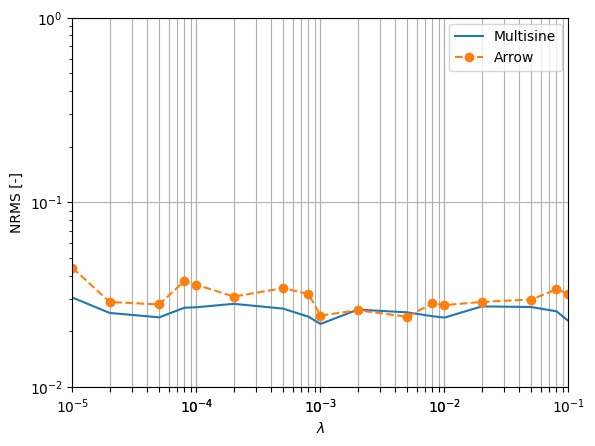

0.025705236550464205
0.030980743153066728
0.0020790334934990724
0.004929773905561321


(None, None)

In [27]:
plt.loglog(np.r_[metrics_df['gamma'].values], np.r_[metrics_df['best_NRMS_test'].values], label="Multisine")
plt.loglog(np.r_[metrics_df['gamma'].values], np.r_[metrics_df['best_NRMS_arrow'].values],"--o", label="Arrow")
plt.ylim([1e-2, 1e-0])
plt.xlim([10**-5, 10**-1])
plt.legend()
plt.xticks(np.r_[[(1+i)*10**-5 for i in range(10)], [(1+i)*10**-4 for i in range(10)], [(1+i)*10**-3 for i in range(10)], [(1+i)*10**-2 for i in range(10)]])
plt.grid()
plt.xlabel("$\\lambda$")
plt.ylabel("NRMS [-]")
# plt.savefig('regularization.png', dpi=450, transparent=True, bbox_inches='tight')
plt.show()

print(np.mean(metrics_df['best_NRMS_test'].values)), print(np.mean(metrics_df['best_NRMS_arrow'].values))

print(np.std(metrics_df['best_NRMS_test'].values)), print(np.std(metrics_df['best_NRMS_arrow'].values))

In [28]:
mu_a = np.mean(metrics_df['best_NRMS_arrow'].values)
mu_m = np.mean(metrics_df['best_NRMS_test'].values)

s_a = np.std(metrics_df['best_NRMS_arrow'].values)
s_m = np.std(metrics_df['best_NRMS_test'].values)

mu_a, mu_m, s_a, s_m

(0.030980743153066728,
 0.025705236550464205,
 0.004929773905561321,
 0.0020790334934990724)